# 02-02 : Multi-label text classification

After extracting intents, we use Keras, a comprehensive deep learning library, to develop a multi-class classification model.

## References

- [Large-scale multi-label text classification](https://keras.io/examples/nlp/multi_label_classification/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional
from IPython.display import display, Markdown

from tensorflow.keras import layers
from tensorflow import keras
import keras_cv
import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-03-18 16:49:47.347320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 16:49:47.347348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 16:49:47.348303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 16:49:47.352969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 16:49:47.860875: W tensorflow/compiler/tf2

Using TensorFlow backend


## 1. Data Description

In [2]:
data_path = '../../data'

orig_data_path = f'{data_path}/hellopeter'
orig_file = f'{orig_data_path}/00-01_vodacom_selected_reviews.parquet.gz'

intent_path = f'{data_path}/multiclass_model'
intent_extract_file = f'{intent_path}/01-03_intents.parquet.gz'
intent_file = f'{intent_path}/02-01_flat_intents.parquet.gz'

### 1.1. Data Lineage

1. The original dataset is a collection publicly accessible customer reviews/complaints scraped from [Hellopeter](https://www.hellopeter.com/) site between 2021 and 2023. This dataset was [created](https://github.com/JohnnyFoulds/dsm050-2023-apr/blob/master/notebooks/01_hellopeter/01-01_retrieve_data.ipynb) in another research project investigating: [Evaluating Customer Satisfaction and Preferences in the Telecommunications Industry: A Comparative Analysis of Survey Data and Online Reviews](https://github.com/JohnnyFoulds/dsm050-2023-apr/blob/master/notebooks/04_draft/04-04_cw02.ipynb)

2. Data selection was perform in the `00-01_data_selection` notebook based on the following criteria.
    - Reviews from the for the 5 month period from **2022-06-01** to **2023-06-30** were selected.

    - Only reviews from the **Vodacom** telecommunications company were selected.

    - Very short, or very long reviews were removed. Reviews between from **10** to **100** words were selected. The word count was calculated using a basic `.str.split().str.len()` which is sufficient for this purpose.

3. The unlabeled data was then labeled in the `01-02_batch_classification` notebook using Generative AI.
    - The **Mistral 7B v0.2** Large Language Model (LLM) were hosted on the local servier with [Ollama](https://ollama.com/library/mistral). Please refer to the `01-01_classification_test` notebook for further details.

    - The classification was done using multiple prompts similar to Chain-of-Thought (CoT) techniques for classification. _Implementation details can be found in the `src` directory._

    - Classification was done based on the categories defined in `src/config/category_definitions.jsonl`.

    - It took an average of **7 seconds** to classify a single review.

4. Using Generative AI for labeling introduced new categories that were cleaned up in the `01-03_cleanup` notebook.

    - First new categories that were prefixed with an original category were replaced.

    - Then, new categories that contained an original category in round brackets were replaced with the original.

    - For the remaining new categories, the reviews were manually inspected and the reviews were reclassified via manual mapping.

5. The data labels was then converted into a format suitable for modeling in the `02-01_data_preperation` notebook.

### 1.2. Data Structure

#### Source Data

The following shows a sample customer review from the original source data.

In [3]:
df_source = pd.read_parquet(orig_file)
with pd.option_context('display.max_colwidth', None):
    display(
        df_source[df_source.id == 3950575]
    )

,id,review_title,review_content
5215,3950575,Vodacom is useless!!!,"Good day\n\nAgain, vodacom did not do their jobs. The amount went off as I explicitly asked for it not to. Vodacom now owes me R300 as it has been debited from my account twice now. I will be taking this to social media now. And I want to please cancel all my contracts with vodacom."


### Data Labels

A sample of the labels extracted using the LLM is shown below. From this we can see that the LLM has extracted multiple labels for each review, and a reason is generated form each label for human verification.

In [4]:
df_intents_extracted = pd.read_parquet(intent_extract_file)
with pd.option_context('display.max_colwidth', None):
    display(
        df_intents_extracted[df_intents_extracted.id == 3950575]
    )

,category,reason,relevance,sentiment,id
29,Billing,The text mentions that an amount was debited from the account twice.,1.0,negative,3950575
30,Cancellation,The text expresses the intent to cancel all contracts with Vodacom due to the billing issue.,1.0,negative,3950575
31,Customer's Feeling,The text contains a negative sentiment towards Vodacom.,0.5,negative,3950575


### Prepared Data Labels

The prepared data labels are shown below. The data labels are prepared for multi-label classification.

This data will need to be combined with the `review_title` and `review_content` from the original source data to create the final dataset for modeling.

In [5]:
df_intents = pd.read_parquet(intent_file)
df_intents["category_list"] = df_intents["category_list"].apply(lambda x: list(x))
df_intents["relevance_list"] = df_intents["relevance_list"].apply(lambda x: list(x))
df_intents["sentiment_list"] = df_intents["sentiment_list"].apply(lambda x: list(x))

with pd.option_context('display.max_colwidth', None):
    display(
        df_intents[df_intents.id == 3950575]
    )

print(f'Data samples: {len(df_source)}')

,id,category_list,relevance_list,sentiment_list
2,3950575,"[Billing, Cancellation, Customer's Feeling]","[1.0, 1.0, 0.5]","[negative, negative, negative]"


Data samples: 5218


## 2. Data Preprocessing

### 2.1. Multi-label Binarization

In [6]:
# get the list of category target values
categories = tf.ragged.constant(df_intents.category_list.values)

# learn the vocabulary
lookup = keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(categories)

# show the vocabulary
vocab = lookup.get_vocabulary()
print("Vocabulary:\n")
print(lookup.get_vocabulary())
print(f'Vocabulary size: {len(vocab)}')

2024-03-18 16:49:48.937883: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-18 16:49:48.967789: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-18 16:49:48.968000: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Vocabulary:

['[UNK]', "Customer's Feeling", 'Billing', 'Network Coverage', 'Cancellation', 'Call Center', 'Policy', 'Account Management', 'Response', 'Resolution', 'Devices', 'Staff Level', 'Price Plans', 'Brand', 'Abuse', 'Products', 'Service', 'Services', 'SIM', 'Other']
Vocabulary size: 20


The following sample illustrates the binarization of the multi-labels. The multiple labels are encoded into a binary matrix where the positions corresponding with the labels have a value of 1.

In [7]:
# find a sample label to test the lookup
sample_label = df_intents[df_intents.id == 3950575].category_list.values[0]

print(f"Original label: {sample_label}")

# binarize the label
label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Billing', 'Cancellation', "Customer's Feeling"]
Label-binarized representation: [[0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


The `invert_multi_hot` function is used to convert the binary matrix back into the original labels.

In [8]:
def invert_multi_hot(encoded_labels, lookup:keras.layers.StringLookup):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    # get the vocabulary
    vocab = lookup.get_vocabulary()

    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

## test the inverse function
invert_multi_hot(label_binarized[0], lookup)

array(["Customer's Feeling", 'Billing', 'Cancellation'], dtype='<U18')

### 2.2. Prepare Dataset

Prepare a dataset for training and testing.

In [9]:
# start from the original label dataset
df_preprocess = df_intents.copy()

# binarize the category_list
labels = tf.ragged.constant(df_preprocess["category_list"].values)
label_binarized = lookup(labels).numpy()
df_preprocess["category_encoded"] = label_binarized.tolist()

# add the review content
df_preprocess = df_preprocess \
    .set_index('id') \
    .join(df_source.set_index('id'), how='left') \
    .assign(review_text=lambda x: '**' + x.review_title + '**\n\n' + x.review_content) \
    .reset_index()

# select the relevant columns
df_preprocess = df_preprocess[['id', 'review_text', 'category_encoded']]

# show a sample of the preprocessed data
with pd.option_context('display.max_colwidth', None):
    display(df_preprocess.head(3))

,id,review_text,category_encoded
0,3950516,"**Vodacom fraudster**\n\nVodacom is a scam! Never ever take, a contract with those people. I had a, contract ending end October. End August I called them and cancelled the contract. I was suprised to find myself at credit bureau while I was looking for a house bond. They didn't cancel my contract. I call them, the system shows I indeed cancel the contract but they don't know why t wasn't cancelled. They are taking me from pillar to post and my life is at a, standstill. Fraudsters","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,3950535,"**bad service**\n\nstill awating any feedback from vodacom legal department ant the email address of DCA Hammond Pole, so that I can forward him all the mails to vodacom that has not been responded by Vodacom, and as stated two times allready, I dont have my number any more so cant phone the DCA, the messages has also been ignored by Vodacom","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,3950575,"**Vodacom is useless!!!**\n\nGood day\n\nAgain, vodacom did not do their jobs. The amount went off as I explicitly asked for it not to. Vodacom now owes me R300 as it has been debited from my account twice now. I will be taking this to social media now. And I want to please cancel all my contracts with vodacom.","[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


### 2.3. Train Test Split

In a multi-label classification problem, imbalance can occur at two levels:

1. **Label imbalance**: Some labels appear more frequently than others.
2. **Label combination imbalance**: Some combinations of labels appear more frequently than others.

Both these imbalances are present in the dataset. Imbalance can lead to a model that performs well on the majority classes but poorly on the minority classes. This is because the model might be biased towards predicting the majority classes due to their higher occurrence in the training data.

To address this, we will ideally use a stratified split to ensure that the distribution of labels in the training and validation sets is similar.

In [10]:
df_category_count = df_intents.category_list.value_counts().reset_index()
df_category_count.columns = ['category', 'samples']

print(f'Combination Category Count  : {len(df_category_count)}')
print(f'Combinations with one sample: {len(df_category_count[df_category_count.samples == 1])}')

Combination Category Count  : 376
Combinations with one sample: 128


Unfortunately we can see that about a third (0.34) of the unique category combinations have only one sample. This means that we will not be able to use a stratified split, as the validation set will not contain any of these unique combinations.

In [11]:
test_split = 0.2

# initial train and test split
train_full_df, test_df = train_test_split(
    df_intents,
    test_size=test_split
)

# splitting the train set further into validation and new train sets
val_df = train_full_df.sample(frac=0.2)
train_df = train_full_df.drop(val_df.index)

# select only the id column
train_full_ids = train_full_df.id.values
train_ids = train_df.id.values
val_ids = val_df.id.values
test_ids = test_df.id.values

# show the record counts per dataset
print(f"Number of rows in training set   : {len(train_ids):>5}")
print(f"Number of rows in validation set : {len(val_ids):>5}")
print(f"Number of rows in test set       : {len(test_ids):>5}")

Number of rows in training set   :  3214
Number of rows in validation set :   803
Number of rows in test set       :  1005


### 2.4. Make Datasets

Use the test-train split to create the final `tf.data.Dataset` objects for modeling.

In [12]:
def make_dataset(ids:np.ndarray, df:pd.DataFrame, batch_size:int=32, shuffle:bool=False):
    """Create a tf.data.Dataset from a pandas DataFrame."""
    # filter the dataframe to only the selected ids
    df = df[df.id.isin(ids)]

    # get the encoded labels and review text
    labels = np.array([np.array(lst) for lst in df.category_encoded.values])
    review_text = df.review_text.values

    # create the dataset
    dataset = tf.data.Dataset.from_tensor_slices((review_text, labels))

    # shuffle the dataset if needed
    if shuffle:
        dataset = dataset.shuffle(batch_size * 10)

    # batch the dataset
    dataset = dataset.batch(batch_size)

    return dataset

Prepare the `tf.data.Dataset` objects.

In [13]:
batch_size = 150

train_dataset = make_dataset(train_ids, df_preprocess, batch_size, shuffle=True)
val_dataset = make_dataset(val_ids, df_preprocess, batch_size, shuffle=False)
test_dataset = make_dataset(test_ids, df_preprocess, batch_size, shuffle=False)

Dataset preview

In [14]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:3]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Review: {text}")
    print(f"Label(s): {invert_multi_hot(label[0], lookup=lookup)}")
    print(" ")

Review: b"**Vodacom scamming people**\n\nI took a new contract with vodacom  online and the consultant lied that the phone is new then when the phone arrived it was old I canceled immediately that ws end of June bt the phone has not been collected till today I have called more than 20 times  but still no one has picked up the phone and yesterday they had the decency to deduct money from my account. Useless bunch of hypocrites. The service is poor they don't deserve to serve anyone"
Label(s): ['Billing' 'Cancellation']
 
Review: b"**Vodacom Fibre**\n\nThey are just trash who take your money and don't give you fibre. Some day - they will get their just deserts and I hope it is soon.\nDespicable. lying, stealing company."
Label(s): ['Brand' 'Abuse']
 
Review: b"**Slow for business fiber installation and you have to pay for temporary solution while waiting**\n\nVery poor service from the company its self they set up they staff for failure \nApplied for a vadacom business package fiber and 

## 3. Evaluation Metrics

Based on the metrics described in the paper titled "CAVES: A Dataset to facilitate Explainable Classification and Summarization of Concerns towards COVID Vaccines" (DOI: 10.48550/arXiv.2204.13746), we have selected the following metrics to estimate the performance of models on our multi-label classification dataset:

1. **F1-Score (Macro-average and Weighted-average)**: 
    - **Justification**: The F1-Score is a harmonic mean of precision and recall, making it a balanced measure that considers both false positives and false negatives. The macro-average F1-Score treats all classes equally, emphasizing the importance of performing well across all classes, including the less frequent ones. The weighted-average F1-Score accounts for class imbalance by weighting the F1-Score of each class by its support (the number of true instances for each label). This is crucial in multi-label classification tasks where some labels may be more prevalent than others.
    - **Calculation & Meaning**: The macro-average F1-Score is calculated by taking the average of the F1-Scores of all classes, while the weighted-average is computed by weighting each class's F1-Score by the number of true instances for that class. These metrics evaluate the model's overall performance across all labels, with macro-averaging treating every class equally and weighted-averaging considering the class distribution.

2. **Jaccard Similarity**:
    - **Justification**: The Jaccard Similarity, or Intersection over Union, is particularly well-suited for multi-label classification. It measures the similarity between the set of predicted labels and the set of true labels by dividing the size of the intersection by the size of the union of the predicted and true label sets. This metric is useful for evaluating performance in multi-label settings where the exact match might be too strict.
    - **Calculation & Meaning**: The Jaccard Similarity is calculated for each instance and then averaged. A higher Jaccard score indicates a greater degree of overlap between the predicted and true labels, signifying better model performance in capturing the multilabel nature of the data.

3. **Subset Accuracy (Exact Match)**:
    - **Justification**: Subset accuracy is the strictest metric, requiring the set of predicted labels to exactly match the set of true labels for an instance to be considered correct. This metric is important in scenarios where the goal is to precisely predict the full set of applicable labels.
    - **Calculation & Meaning**: Subset accuracy is the proportion of instances for which the predicted label set exactly matches the true label set. It provides a clear indication of the model's ability to perfectly predict label sets, though it may be too stringent for some multi-label applications.

In [15]:
from sklearn.metrics import f1_score, jaccard_score, accuracy_score

class Evaluation:

    @staticmethod
    def f1_score_macro(y_true, y_pred):
        """Calculate F1-score (Macro-Average)."""
        return f1_score(y_true, y_pred, average='macro', zero_division=0)

    @staticmethod
    def f1_score_weighted(y_true, y_pred):
        """Calculate F1-score (Weighted-Average)."""
        return f1_score(y_true, y_pred, average='weighted', zero_division=0)

    @staticmethod
    def jaccard_similarity(y_true, y_pred):
        """Calculate average Jaccard Similarity."""
        return jaccard_score(y_true, y_pred, average='samples')

    @staticmethod
    def subset_accuracy(y_true, y_pred):
        """Calculate Subset Accuracy (Exact Match Accuracy)."""
        return accuracy_score(y_true, y_pred)

    @staticmethod
    def evaluate_all(y_true, y_pred):
        """Evaluate all metrics and display a summary."""
        f1_macro = Evaluation.f1_score_macro(y_true, y_pred)
        f1_weighted = Evaluation.f1_score_weighted(y_true, y_pred)
        jaccard_similarity = Evaluation.jaccard_similarity(y_true, y_pred)
        subset_accuracy = Evaluation.subset_accuracy(y_true, y_pred)

        # Display a summary of the evaluation
        print(f"F1 Score (Macro-Average)   \t{f1_macro:.3f}")
        print(f"F1 Score (Weighted-Average)\t{f1_weighted:.3f}")
        print(f"Average Jaccard Similarity \t{jaccard_similarity:.3f}")
        print(f"Subset Accuracy            \t{subset_accuracy:.3f}")

# Example usage:
# Assuming y_true and y_pred are your true and predicted labels respectively
# Evaluation.evaluate_all(y_true, y_pred)

In [16]:
def evaluate_model(model:keras.Model,
                   dataset:tf.data.Dataset,
                   threshold:float=0.5,
                   verbose:int=1):
    """Evaluate the model using the Evaluation class."""
    # get the true labels
    y_true = np.concatenate([label_batch.numpy() for _, label_batch in dataset], axis=0)

    # get the predicted labels
    y_pred = model.predict(dataset, verbose=verbose)
    y_pred = y_pred > threshold

    # evaluate the model
    if verbose:
        print()

    Evaluation.evaluate_all(y_true, y_pred)

In [17]:
def show_model_evaluation(model:keras.Model, verbose:int=1):
    """Show the validation results for the model."""
    global train_dataset
    global val_dataset
    global test_dataset 

    print("--- Training ------------------------")
    evaluate_model(model, train_dataset, verbose=verbose)
    print()

    print("--- Validation ----------------------")
    evaluate_model(model, val_dataset, verbose=verbose)
    print()

    print("--- Test ----------------------------")
    evaluate_model(model, test_dataset, verbose=verbose)

## 4. Modeling

In [18]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

### 4.1. Vectorization

Before we can train a model, we need to convert the text data into a format that can be fed into the model. There are multiple ways to do this, but a common approach is to convert text data into numerical data using a method such as TF-IDF, word embeddings, or a pre-trained language model.

For this purpose we will use the a `TextVectorization` layer that can operate as part of the main model so that the model is excluded from the core preprocessing logic. As noted in the [Keras documentation](https://keras.io/examples/nlp/multi_label_classification/) this also greatly reduces the chances of training / serving skew during inference.

Calculate the number of unique words in the dataset and the maximum length of a review.  
_We expect the maximum review length to be 100 words as we have filtered the reviews to be between 10 and 100 words._

In [19]:
# calculate the number of unique words in the dataset
vocabulary = set()
df_preprocess.review_text.str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(f'Vocabulary size: {vocabulary_size}')

# get the maximum length of a review
max_review_length = int(df_preprocess.review_text.str.split().apply(len).max())
print(f'Maximum review length: {max_review_length}')

Vocabulary size: 20646
Maximum review length: 100


We will initial use a very simple `TextVectorization` layer with `'int'` output mode. In later iterations we can experiment with different vectorization layers,parameters, and output modes like `'tf-idf'` which is a simple, but quite effective technique in NLP text classification tasks.

In [20]:
def create_vectorizer(
        texts:List[str],
        max_tokens:int,
        output_mode:str='int',
        output_sequence_length:Optional[int]=None,
        ngrams:Optional[int]=None):
    """Create and adapt a vectorization layer for the given texts."""
    # create the layer
    text_vectorizer = layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode=output_mode,
        output_sequence_length=output_sequence_length,
        ngrams=ngrams
    )

    # adapt the layer to the texts
    text_vectorizer.adapt(texts)

    return text_vectorizer

In [21]:
# create the vectorizer
text_vectorizer_layer = create_vectorizer(
    df_preprocess.review_text.values,
    max_tokens=vocabulary_size,
    output_mode='int',
    output_sequence_length=max_review_length
)

In [22]:
# test the vectorizer
sample_review = df_preprocess[df_preprocess.id == 3950575].review_text.values[0]
display(Markdown(sample_review))
print(f"Vectorized review: {text_vectorizer_layer([sample_review])}")

**Vodacom is useless!!!**

Good day

Again, vodacom did not do their jobs. The amount went off as I explicitly asked for it not to. Vodacom now owes me R300 as it has been debited from my account twice now. I will be taking this to social media now. And I want to please cancel all my contracts with vodacom.

Vectorized review: [[   6    9  116  247  126   91    6  108   16   46   49 1854    4  193
   169  148   41    2 3769  252   10   22   16    3    6   32 3025   14
  1632   41   22   36   28  256   26    8   39  463   32    2   42   34
   269   20    3  910  958   32    5    2   87    3   73   68   58    8
   177   17    6    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


### 4.2. Baseline

For a multi-label text classification task in Natural Language Processing (NLP), a commonsense baseline could be designed using simple heuristics based on the frequency of specific keywords or phrases associated with each label. Multi-label classification differs from binary or multi-class classification in that each text instance can be associated with multiple labels simultaneously, rather than belonging to just one category.

To accomplish this we could start with  simple libraries like the [Natural Laugage Toolkit (NLTK)](https://www.nltk.org/) to tokenize the text and count the frequency of specific words or phrases associated with each label. We could then use these frequencies to predict the labels for new text instances. However for the sake of simplicity we will instead start with a very basic deep learning model.

In [23]:
def make_baseline_model(
        vectorization_layer: layers.TextVectorization,
        output_units:int,
        dense_units:(List[int]),
        dense_activation:Optional[str]='relu') -> keras.Model:
    """Create a simple feed-forward model that can be used as a baseline."""
    model = keras.Sequential()

    # add the vectorization layer
    model.add(vectorization_layer)

    # add the dense layers
    for units in dense_units:
        model.add(layers.Dense(units, activation=dense_activation))

    # add the output layer
    model.add(layers.Dense(output_units, activation='sigmoid', name='output'))

    return model

#### Create a text classification model

In [24]:
def create_baseline_model() -> keras.Model:
    """Create the baseline model with specific hyperparameters
    for reuse in other experiments.
    """
    global text_vectorizer_layer
    global lookup

    return make_baseline_model(
        text_vectorizer_layer,
        output_units=len(lookup.get_vocabulary()),
        dense_units=[512],
        dense_activation='relu'
    )

In [25]:
# get the baseline model
baseline_model = create_baseline_model()
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 dense (Dense)               (None, 512)               51712     
                                                                 
 output (Dense)              (None, 20)                10260     
                                                                 
Total params: 61972 (242.08 KB)
Trainable params: 61972 (242.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Train the model

In [26]:
epochs = 50

In [27]:
# compile the model
baseline_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0),
    optimizer='adam',
    metrics=['binary_accuracy'])

In [28]:
# train the model
history = baseline_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=0
)

2024-03-18 16:49:51.527363: I external/local_xla/xla/service/service.cc:168] XLA service 0x701e4a0072b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-18 16:49:51.527381: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-03-18 16:49:51.531003: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-18 16:49:51.542668: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710773391.601526  771962 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


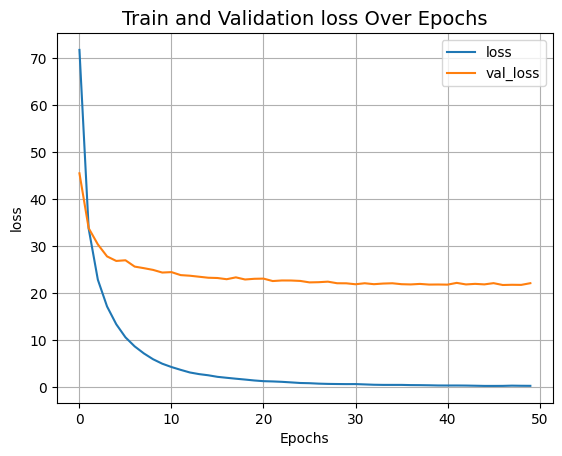

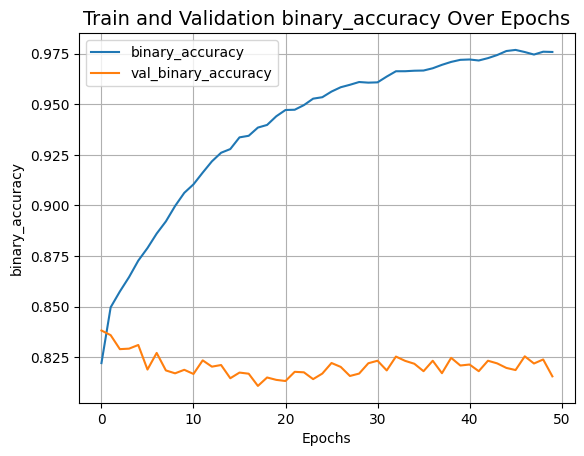

In [29]:
plot_result("loss")
plot_result("binary_accuracy")

#### Evaluate the model

From the evaluation results below we can see that wile the baseline model appears to perform well when considering the **Categorical accuracy** it performs poorly when considering the **F1-Score** and **Jaccard Similarity**.

First we need to understand the **Binary Accuracy** metric as reported by Keras. This metric treats each label as a separate binary classification problem. It calculates the percentage of correctly predicted labels (both positive and negative) across all labels and instances. High binary accuracy indicates that, on average, the model is good at deciding whether a specific label should be applied or not, but it doesn't consider the exact set of labels for each instance.

##### Diagnosing the Issue

1. **Class Imbalance**: If some labels are much more frequent than others, the model might learn to predict these labels more accurately, contributing to high binary accuracy. However, rare labels might be poorly predicted, which affects F1 scores and Jaccard similarity negatively.

2. **Label Correlations**: In real-world data, labels can be correlated (e.g., "Network Coverage" and "Service" might often appear together). If the model fails to capture these correlations, it might still achieve good binary accuracy by getting many labels right based on their individual occurrences but fail at accurately capturing the relationships between labels, which is crucial for high F1 scores and Jaccard similarity.

3. **Thresholding**: The way you convert model outputs (probabilities) into label predictions (binary) can significantly impact performance. The default threshold is 0.5, but adjusting this threshold might improve F1 scores and Jaccard similarity.

##### Improving The Model

The following are potential strategies for improving the model:

1. **Model Architecture**: Experiment with different model architectures, layers, and hyperparameters. Attention mechanisms or more sophisticated RNNs and CNNs might capture label correlations better.

2. **Class Weights**: Adjust class weights to handle imbalanced data better, making the model pay more attention to rare labels.

3. **Evaluation Metric Optimization**: Instead of optimizing for binary accuracy during training, consider optimizing directly for metrics more aligned with your actual goals, like F1 score or Jaccard index, if possible.

4. **Threshold Tuning**: Experiment with different thresholds for converting probabilities to binary labels, or consider using ranking-based metrics if thresholding proves problematic.


> ❗️As discussed in a previous section, the dataset is imbalanced at both the label and label combination levels. This imbalance is likely contributing to the discrepancy between the binary accuracy and the F1 scores and Jaccard similarity.

In [30]:
_, binary_acc = baseline_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

7/7 [==============================] - 0s 2ms/step - loss: 23.3633 - binary_accuracy: 0.8206
Categorical accuracy on the test set: 82.06%.


Calculate the relevant evaluation metrics using the `Evaluation` class for a more detailed analysis.

In [31]:
show_model_evaluation(baseline_model, verbose=0)

--- Training ------------------------
F1 Score (Macro-Average)   	0.106
F1 Score (Weighted-Average)	0.220
Average Jaccard Similarity 	0.148
Subset Accuracy            	0.016

--- Validation ----------------------
F1 Score (Macro-Average)   	0.104
F1 Score (Weighted-Average)	0.227
Average Jaccard Similarity 	0.137
Subset Accuracy            	0.006

--- Test ----------------------------
F1 Score (Macro-Average)   	0.126
F1 Score (Weighted-Average)	0.235
Average Jaccard Similarity 	0.146
Subset Accuracy            	0.012


### 4.3. Class Weights

 The distribution of classes can significantly impact model performance. As already seen, our dataset exhibit a class imbalance, where some classes are underrepresented compared to others. This imbalance can lead to models that are biased towards the majority class, at the expense of accurately predicting minority class instances.

To mitigate this issue, we will experiment with class weights. Class weighting is a technique that adjusts the importance of each class during the training process, based on the inverse of their frequencies. By assigning higher weights to underrepresented classes, the model is penalized more for misclassifying these classes, encouraging it to pay more attention to them.

The method we will use involves calculating the class weights based on the training dataset's class distribution. These weights are then applied to the loss function during model training, effectively altering the training dynamics to favor an equitable representation of classes in the model's predictions. This approach is straightforward to implement and has been shown to improve model performance on imbalanced datasets

#### 4.3.1 Calculate Label Weights

First, we need to determine the frequency of each label in your dataset. This involves counting how many times each label appears across all samples.

In [32]:
def calculate_label_weights(y_train):
    """Calculate label weights based on inverse label frequency."""
    label_frequencies = np.sum(y_train, axis=0)
    label_weights = len(y_train) / (label_frequencies + 1e-9)  # Adding a small value to avoid division by zero
    label_weights /= np.min(label_weights)  # Optional normalization
    return label_weights

In [33]:
y_train = y_train = np.concatenate([label_batch.numpy() for _, label_batch in train_dataset], axis=0)
label_weights = calculate_label_weights(y_train)

#### 4.3.2 Label Weights in Loss Calculation

Define a custom loss metric based on `tf.keras.losses.binary_crossentropy` that incorporates the calculated class weights.

In [34]:
def weighted_binary_crossentropy(y_true, y_pred, weights):
    """
    Weighted binary cross-entropy loss for multi-label classification.
    
    Args:
    - y_true: True labels.
    - y_pred: Predictions.
    - weights: Array of shape (num_labels,) containing the weight for each label.
    
    Returns:
    - Weighted loss.
    """
    # Convert weights to a tensor
    weights = tf.constant(weights, dtype=tf.float32)
    
    # Calculate the binary cross-entropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Expand weights to match the shape of y_true and y_pred
    weights = tf.reduce_mean(weights * y_true, axis=-1)
    
    # Apply the weights
    weighted_bce = bce * weights
    
    # Return the mean loss
    return tf.reduce_mean(weighted_bce)

def get_weighted_loss(weights):
    """Implements wrapping the custom loss with the calculated weights"""
    def loss(y_true, y_pred):
        return weighted_binary_crossentropy(y_true, y_pred, weights)
    return loss

#### 4.3.3 Model Training

In [35]:
# we will use the same baseline model architecture as before
weight_model = create_baseline_model()

# compile the model with the new metrics
weight_model.compile(
    loss=get_weighted_loss(label_weights),
    optimizer='adam',
    metrics=['binary_accuracy'])

In [36]:
# train the model
history = weight_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=epochs,
    verbose=0
)

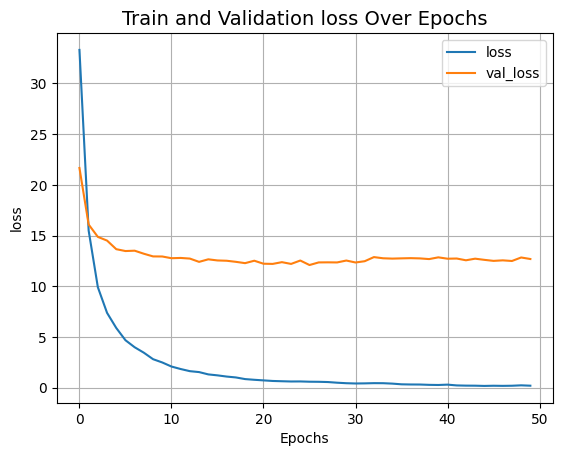

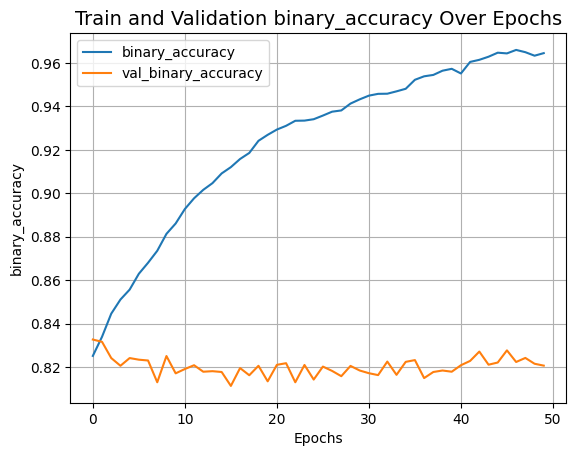

In [37]:
# plot the training history
plot_result("loss")
plot_result("binary_accuracy")

In [38]:
show_model_evaluation(weight_model, verbose=0)

--- Training ------------------------
F1 Score (Macro-Average)   	0.099
F1 Score (Weighted-Average)	0.209
Average Jaccard Similarity 	0.135
Subset Accuracy            	0.013

--- Validation ----------------------
F1 Score (Macro-Average)   	0.108
F1 Score (Weighted-Average)	0.219
Average Jaccard Similarity 	0.132
Subset Accuracy            	0.005

--- Test ----------------------------
F1 Score (Macro-Average)   	0.108
F1 Score (Weighted-Average)	0.222
Average Jaccard Similarity 	0.132
Subset Accuracy            	0.006


#### 4.3.4 Analysis

It is clear that the `binary_accuracy` metric is completely inappropriate for this multi-label classification task. Even when we attempt to apply class weights to the loss function, the `binary_accuracy` metric keeps improving, but the important metrics like `f1_score` and `jaccard_score` do not improve.

An alternative metric list [Focal Loss](https://arxiv.org/abs/1708.02002) could potentially be considered.

### 4.4. Focal Loss

Our Final attempt with the loss function will be to look at using Focal Loss as an alternative. Additional training metrics are also introduced to monitor the model's performance.

#### 4.4.1 Model Training

In [39]:
# we will use the same baseline model architecture as before
focal_model = create_baseline_model()

# compile the model with the new metrics
focal_model.compile(
    loss=keras_cv.losses.FocalLoss(alpha=0.5, gamma=2, label_smoothing=0),
    optimizer='adam',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')])

In [40]:
# train the model
history = focal_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=epochs,
    verbose=0
)

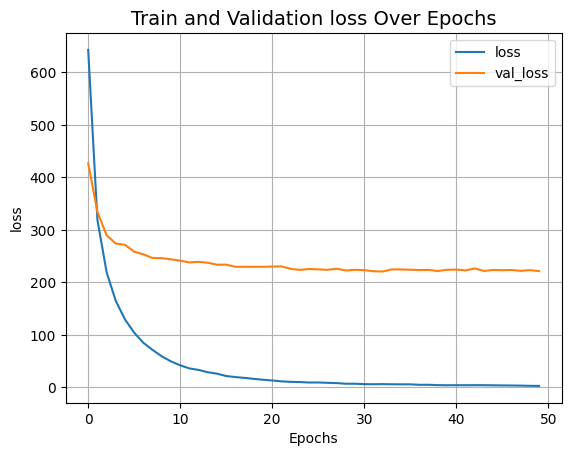

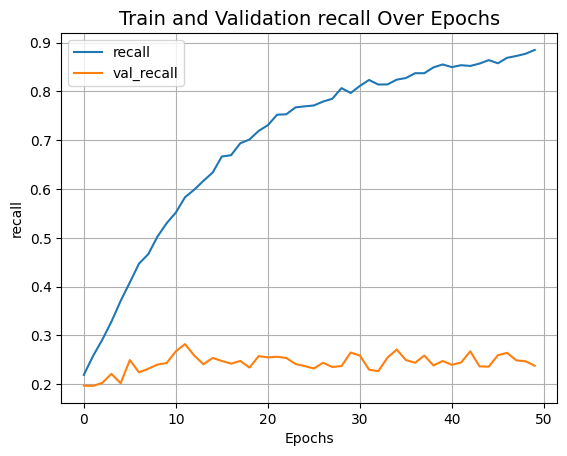

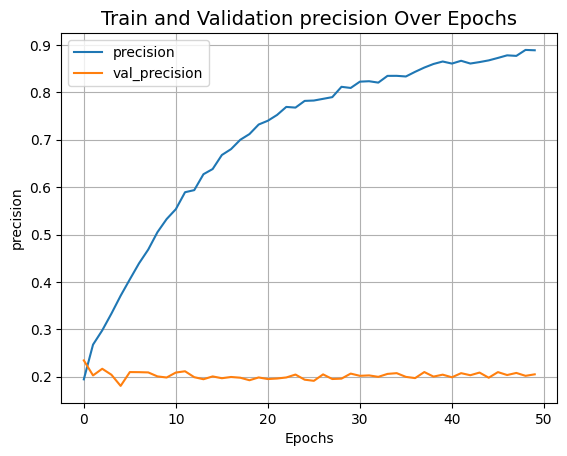

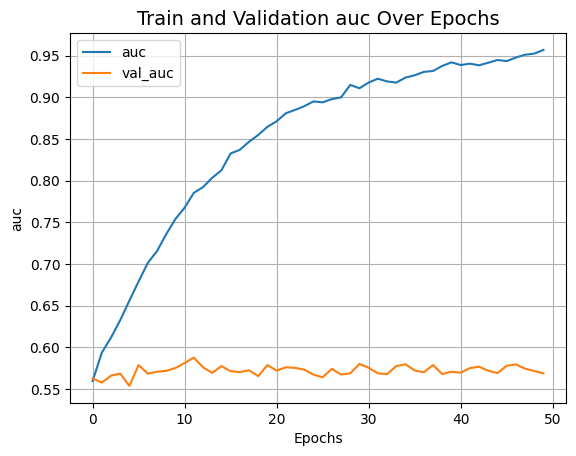

In [41]:
plot_result("loss")
plot_result("recall")
plot_result("precision")
plot_result("auc")

In [42]:
show_model_evaluation(focal_model, verbose=0)

--- Training ------------------------
F1 Score (Macro-Average)   	0.100
F1 Score (Weighted-Average)	0.208
Average Jaccard Similarity 	0.141
Subset Accuracy            	0.016

--- Validation ----------------------
F1 Score (Macro-Average)   	0.109
F1 Score (Weighted-Average)	0.230
Average Jaccard Similarity 	0.141
Subset Accuracy            	0.010

--- Test ----------------------------
F1 Score (Macro-Average)   	0.133
F1 Score (Weighted-Average)	0.242
Average Jaccard Similarity 	0.156
Subset Accuracy            	0.008


#### 4.4.2 Analysis

Unfortunately the alternative loss function also did not improve the model's performance. This concludes experimentation attempting to handle the class imbalance either through class weights or alternative loss functions. 

### 4.5 Embedding Layer

For text classification, a common approach is to use an embedding layer followed by one or more dense layers. In this section we will extend our original baseline model by adding an embedding layer. The embedding layer learns a dense representation for each token in the input text. This dense representation is then used as the input to the following dense layers.

In [43]:
def make_embedding_model(
        vectorization_layer: layers.TextVectorization,
        output_units:int,
        embedding_dim:int,
        dense_units:(List[int]),
        dense_activation:Optional[str]='relu') -> keras.Model:
    """Create a simple feed-forward model that can be used as a baseline."""
    model = keras.Sequential()

    # add the vectorization layer
    model.add(vectorization_layer)

    # add the embedding layer
    model.add(layers.Embedding(
        input_dim=len(vectorization_layer.get_vocabulary()),
        output_dim=embedding_dim))

    # add a flatten label
    model.add(layers.Flatten())      

    # add the dense layers
    for units in dense_units:
        model.add(layers.Dense(units, activation=dense_activation))

    # add the output layer
    model.add(layers.Dense(output_units, activation='sigmoid', name='output'))

    return model

### 4.5.1 Extra Layer Only

We will use the same model architecture as the baseline model, but with the addition of an embedding layer. None of the other model parameters will be changed for this initial experiment.

In [44]:
# create the model
embedding_only_model = make_embedding_model(
    vectorization_layer=text_vectorizer_layer,
    output_units=len(lookup.get_vocabulary()),
    embedding_dim=16,
    dense_units=[512],
    dense_activation='relu'
)

embedding_only_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 16)           190272    
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               819712    
                                                                 
 output (Dense)              (None, 20)                10260     
                                                                 
Total params: 1020244 (3.89 MB)
Trainable params: 1020244 (3.89 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [45]:
# compile the model
embedding_only_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0),
    optimizer='adam',
    metrics=['binary_accuracy'])

# train the model
history = embedding_only_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=0
)

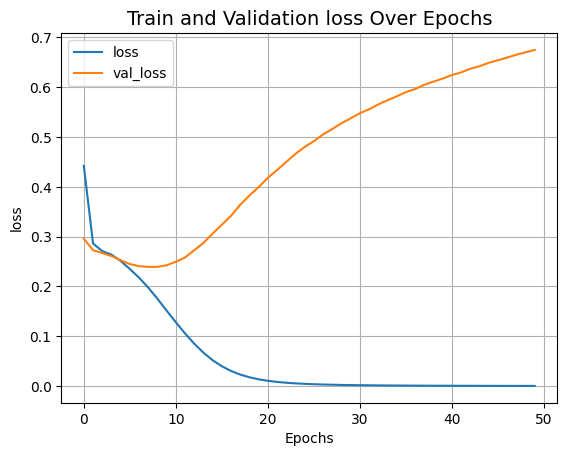

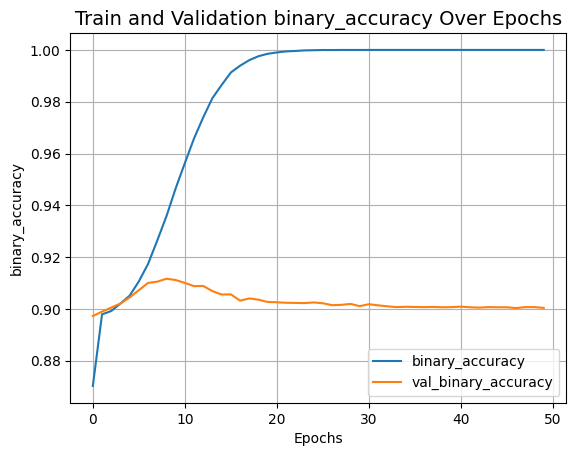

In [46]:
plot_result("loss")
plot_result("binary_accuracy")

In [47]:
show_model_evaluation(embedding_only_model, verbose=0)

--- Training ------------------------
F1 Score (Macro-Average)   	0.108
F1 Score (Weighted-Average)	0.228
Average Jaccard Similarity 	0.158
Subset Accuracy            	0.024

--- Validation ----------------------
F1 Score (Macro-Average)   	0.160
F1 Score (Weighted-Average)	0.359
Average Jaccard Similarity 	0.274
Subset Accuracy            	0.056

--- Test ----------------------------
F1 Score (Macro-Average)   	0.178
F1 Score (Weighted-Average)	0.362
Average Jaccard Similarity 	0.277
Subset Accuracy            	0.072
